In [1]:
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
from mpl_toolkits.axes_grid1 import make_axes_locatable
import itertools
import matplotlib as mpl
import sys
import powerbox as pbox

from nbodykit.lab import *

from colossus.cosmology import cosmology
cosmo_c = cosmology.setCosmology('planck15')

In [2]:
def measure_autopk(array,L):
    mesh = ArrayMesh(array,BoxSize=L)
    r = FFTPower(mesh, mode='1d')
    return r.power

In [3]:
def noise(nc):
    np.random.seed(0)
    # Build a unit-distribution of complex numbers with random phase
    a = np.random.normal(loc=0, scale=1, size=(nc,nc,nc))
    b = np.random.normal(loc=0, scale=1, size=(nc,nc,nc))
    return a + 1j * b

In [4]:
L=512
nc=256
wn = noise(nc)
a = measure_autopk(wn,L)

[]

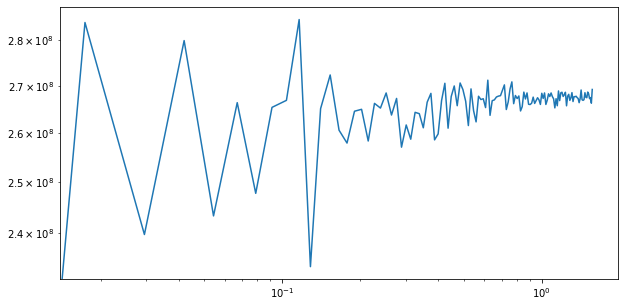

In [5]:
plt.figure(figsize=(10,5))
plt.plot(a['k'].real,a['power'].real)
plt.loglog()

In [6]:
k,p = np.loadtxt('Pk.input_zinit_normalized_at_z0.DAT',unpack=True)
p*=cosmo_c.growthFactor(100)*cosmo_c.growthFactor(100)

In [7]:
"""Create k^2 in box (nc x nc x nc)"""
def k_box(nc,L):
    kfac = 2.*np.pi/L
    k= np.fft.fftfreq(nc,d=1./nc/kfac) #d controls spacing
    a = np.transpose(np.indices((nc,nc,nc)).T, (2, 1, 0, 3)) #1 grid cell 3 coordinates
    k2=(k[a]**2).sum(axis=-1) # each grid cell is sum of squares of coordinates
    return (np.sqrt(k2.astype(np.float16)))

In [8]:
kbox = k_box(nc,L)

In [9]:
"""
def pk(kval):
    return np.interp(kval,k,p)
pb = pbox.PowerBox(N=nc,dim=3,pk=pk,boxlength=L)
wnpkbox = pb.delta_x()
"""

'\ndef pk(kval):\n    return np.interp(kval,k,p)\npb = pbox.PowerBox(N=nc,dim=3,pk=pk,boxlength=L)\nwnpkbox = pb.delta_x()\n'

In [10]:
Pk_box = np.interp(kbox,k,p)

In [11]:
wnpk = wn *np.sqrt(Pk_box/L**(3)*nc**(6))
a1 = np.fft.ifftn(wnpk)

In [12]:
b1 = measure_autopk(a1.real,L)
#b3 = measure_autopk(wnpkbox.real,L)

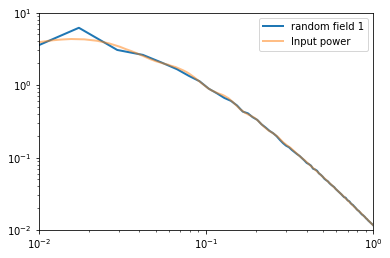

In [13]:
plt.plot(b1['k'].real,b1['power'].real,lw=2,label="random field 1")
#plt.plot(b3['k'].real,b3['power'].real,lw=2,label="random field 3")

plt.plot(k,p,alpha=0.5,lw=2,label="Input power")
plt.loglog()
plt.xlim(0.01,1)
plt.ylim(1E-2,1E1)
plt.legend()

In [361]:
def plot_slice(a1,start):
    cmap = plt.get_cmap('jet')
    start = start
    #num=1
    #end = start+num
    #c = a1[:,start:end,:].mean(axis=1)
    c = a1[:,start,:]
    #c = scipy.ndimage.interpolation.zoom(c ,order=1, zoom=2)

    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(111)

    im = plt.imshow((c.T),vmin=-.1,vmax=0.1,interpolation='bilinear',origin='lower',aspect='auto',cmap=cmap)
    ax.set_aspect('equal')

    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", "5%", pad="2%")
    cb = plt.colorbar(im,orientation='vertical',cax=cax)
    cb.ax.get_yaxis().labelpad = 0.
    plt.show()

In [15]:
#plot_slice(wnpkbox.real,int(nc/2))

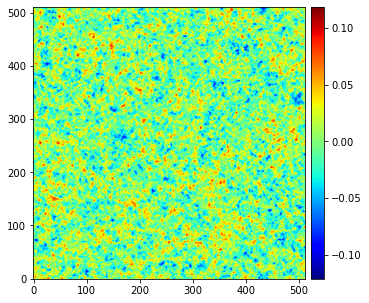

In [16]:
plot_slice(a1.real,int(nc/2))

In [17]:
"""Augment resolution in Fourier space"""
nc2 = 2*nc
kbox2 = k_box(nc2,L)
Pk_box2 = np.interp(kbox2,k,p)

In [18]:
wn2 = noise(nc2)
wnpk2 = wn2 * np.sqrt(Pk_box2/L**(3)*(nc2)**(6))
a2 = np.fft.ifftn(wnpk2)

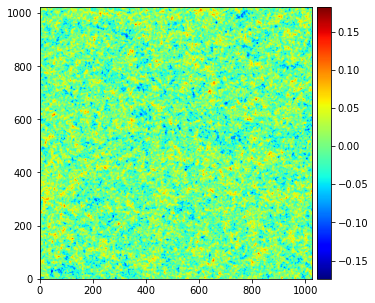

In [19]:
plot_slice(a2.real,int(nc2/2))

In [20]:
b2 = measure_autopk(a2.real,L)

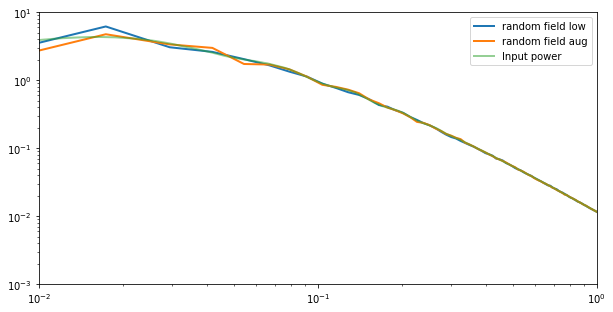

In [21]:
plt.figure(figsize=(10,5))
plt.plot(b1['k'].real,b1['power'].real,lw=2,label="random field low")
plt.plot(b2['k'].real,b2['power'].real,lw=2,label="random field aug")
plt.plot(k,p,alpha=0.5,lw=2,label="Input power")
plt.loglog()
plt.xlim(0.01,1)
plt.ylim(1E-3,1E1)
plt.legend()

In [230]:
"""Create k^2 in box (nc x nc x nc)"""
def k_ind_box(nc,L):
    kfac = 2.*np.pi/L
    k= np.fft.fftfreq(nc,d=1./nc/kfac) #d controls spacing
    a = np.transpose(np.indices((nc,nc,nc),dtype=np.float32).T, (2, 1, 0, 3)) #1 grid cell 3 coordinates
    return (a.astype(np.int))

In [30]:
delta_lin = np.fromfile('deltaLOGN_1000.dat',dtype=np.float32).reshape(nc,nc,nc)
delta_lin[120:130,120:130,120:130]=+0.7
delta_lin[60:70,120:130,60:70]=+0.7
delta_lin[200:210,120:130,200:210]=+0.7
delta_lin[60:70,120:130,200:210]=+0.7
delta_lin[200:210,120:130,60:70]=+0.7

In [31]:
pk_delta = measure_autopk(delta_lin,L)

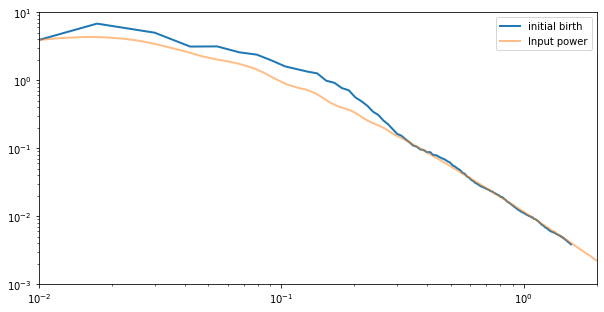

In [32]:
plt.figure(figsize=(10,5))
plt.plot(pk_delta['k'].real,pk_delta['power'].real,lw=2,label="initial birth")
plt.plot(k,p,alpha=0.5,lw=2,label="Input power")
plt.loglog()
plt.xlim(0.01,2)
plt.ylim(1E-3,1E1)
plt.legend()

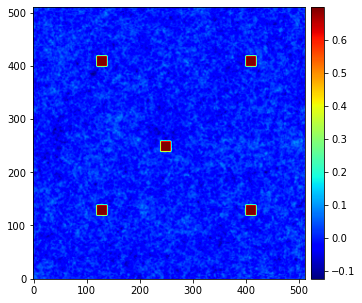

In [33]:
plot_slice(delta_lin,int(nc/2))

In [34]:
grf2 = np.fft.ifftn(wnpk2).real

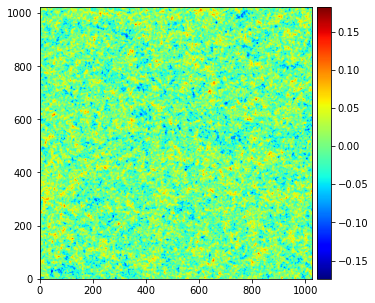

In [35]:
plot_slice(grf2,int(nc2/2))

In [36]:
kboxind =  k_ind_box(nc,L)

In [37]:
kboxind2 =  k_ind_box(nc2,L)

In [38]:
iind = np.isin(kboxind2,kboxind)
ii = iind.all(axis=-1)

In [39]:
delta_k = np.fft.fftn(delta_lin)
#delta_k = np.fft.fftshift(delta_k)

In [40]:
wnpk2c = np.copy(wnpk2)
#wnpk2c = np.fft.fftshift(wnpk2c)

In [41]:
wnpk2c[ii]=delta_k.ravel() #*np.sqrt(nc**(6)/L**(3))

In [42]:
grf2c = np.fft.ifftn(wnpk2c)

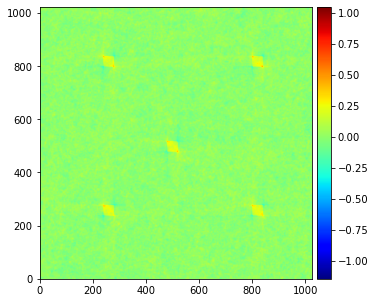

In [43]:
plot_slice(grf2c.real,int(nc2/2))

In [44]:
pk_delta = measure_autopk(grf2c,L)

In [45]:
np.where(ii==True)[0].shape

(16777216,)

In [46]:
wnpk2[ii]=0

In [48]:
aa = k_ind_box(2,L)

In [49]:
bb = k_ind_box(4,L)

In [268]:
delta_test = np.fromfile('HRwhite_noise_cosmos_1200.dat',dtype=np.int16).reshape(nc2,nc2,nc2)

ValueError: cannot reshape array of size 268435456 into shape (512,512,512)

In [52]:
pk_delta = measure_autopk(a2.real,L)

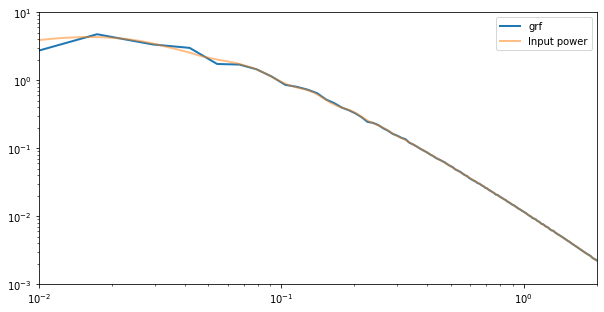

In [53]:
plt.figure(figsize=(10,5))
plt.plot(pk_delta['k'].real,pk_delta['power'].real,lw=2,label="grf")
plt.plot(k,p,alpha=0.5,lw=2,label="Input power")
plt.loglog()
plt.xlim(0.01,2)
plt.ylim(1E-3,1E1)
plt.legend()

In [54]:
wnpk2c = np.copy(wnpk2)

In [55]:
wnpk2c[ii].real=delta_k.ravel().real*8

In [56]:
wnpk2c[ii].imag=delta_k.ravel().imag*8

In [57]:
grf2c = np.fft.ifftn(wnpk2c)

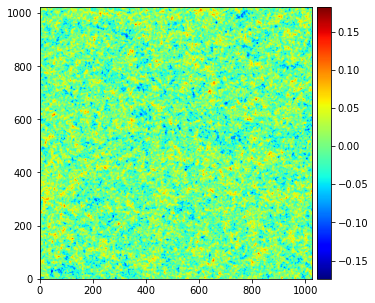

In [58]:
plot_slice(grf2c.real,int(nc2/2))

In [59]:
t = np.zeros((nc2,nc2,nc2),dtype=np.complex64)

In [60]:
t[ii]=delta_k.ravel()*8

In [61]:
t[np.invert(ii)]=wnpk2c[np.invert(ii)]

In [62]:
tr = np.fft.ifftn(t)

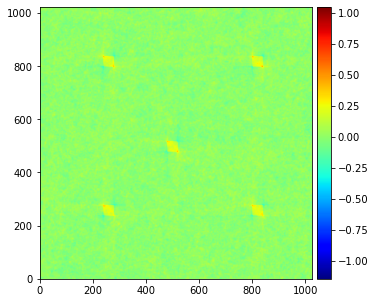

In [63]:
plot_slice(tr.real,int(nc2/2))

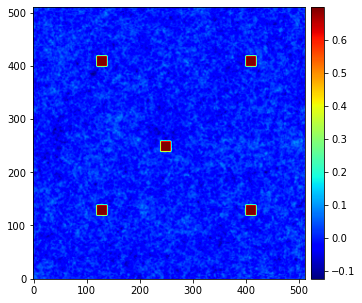

In [64]:
plot_slice(delta_lin.real,int(nc/2))

In [65]:
pk_delta = measure_autopk(tr.real,L)

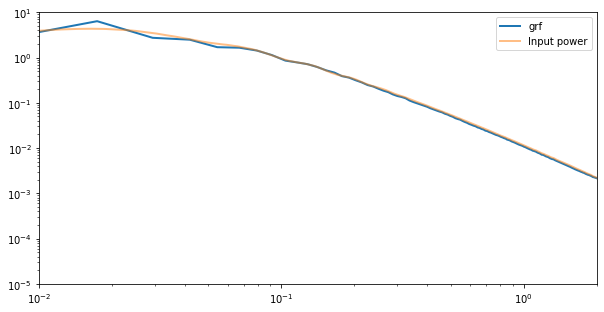

In [66]:
plt.figure(figsize=(10,5))
plt.plot(pk_delta['k'].real,pk_delta['power'].real,lw=2,label="grf")
plt.plot(k,p,alpha=0.5,lw=2,label="Input power")
plt.loglog()
plt.xlim(0.01,2)
plt.ylim(1E-5,1E1)
plt.legend()

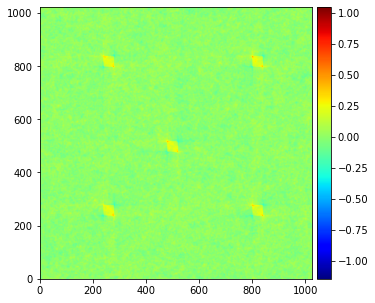

In [67]:
plot_slice(tr.real.T,int(nc2/2))

In [68]:
k,p = np.loadtxt('Pk.input_zinit_normalized_at_z0.DAT',unpack=True)
p*=cosmo_c.growthFactor(100)*cosmo_c.growthFactor(100)

In [69]:
p[2500:2700] = 30
p[3055:3300] = 15
p[3555:3900] = 0.5


In [70]:
Pk_boxtest = np.interp(kbox,k,p)

In [71]:
wnpk = wn *np.sqrt(Pk_boxtest/L**(3)*nc**(6))


In [72]:
a1 = np.fft.ifftn(wnpk)
b1 = measure_autopk(a1.real,L)


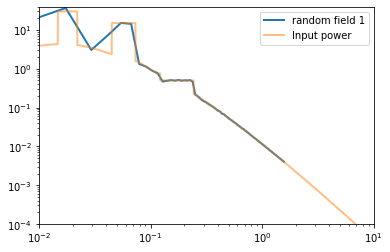

In [73]:
plt.plot(b1['k'].real,b1['power'].real,lw=2,label="random field 1")
#plt.plot(b3['k'].real,b3['power'].real,lw=2,label="random field 3")

plt.plot(k,p,alpha=0.5,lw=2,label="Input power")
plt.loglog()
plt.xlim(0.01,10)
plt.ylim(1E-4,4E1)
plt.legend()

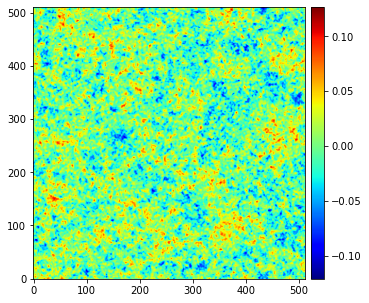

In [74]:
plot_slice(a1.real,int(nc/2))

In [75]:
t = np.zeros((nc2,nc2,nc2),dtype=np.complex64)
t[ii]=wnpk.ravel()
t[np.invert(ii)]=wnpk2c[np.invert(ii)]
tr = np.fft.ifftn(t)
pk_delta = measure_autopk(tr.real,L)

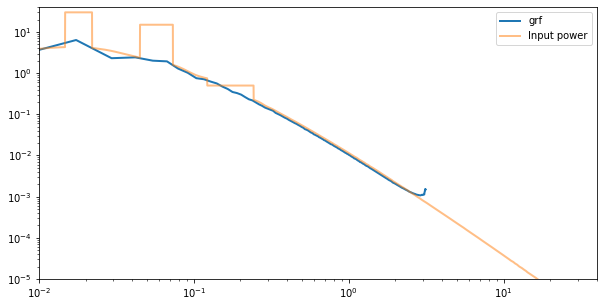

In [76]:
plt.figure(figsize=(10,5))
plt.plot(pk_delta['k'].real,pk_delta['power'].real,lw=2,label="grf")
plt.plot(k,p,alpha=0.5,lw=2,label="Input power")
plt.loglog()
plt.xlim(0.01,40)
plt.ylim(1E-5,4E1)
plt.legend()

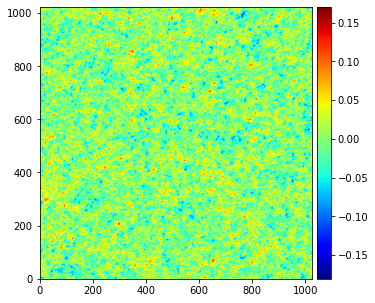

In [77]:
plot_slice(tr.real,int(nc2/2))

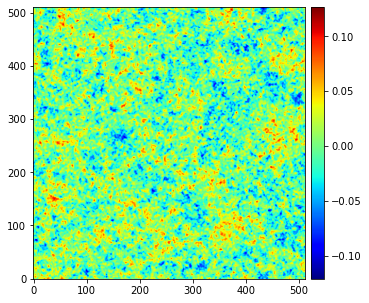

In [78]:
plot_slice(a1.real,int(nc/2))

(array([3753042., 2199496., 3004543., 3458934., 2179288., 1310215.,
         608688.,  201586.,   53323.,    8101.]),
 array([0.   , 0.54 , 1.08 , 1.619, 2.16 , 2.7  , 3.238, 3.78 , 4.32 ,
        4.86 , 5.4  ], dtype=float16),
 <BarContainer object of 10 artists>)

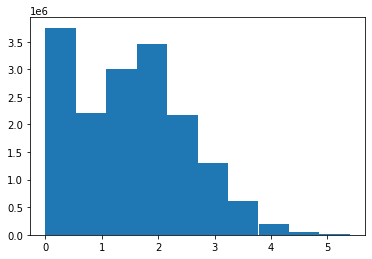

In [85]:
plt.hist(kbox2[ii].T-kbox.ravel())

In [123]:
np.argsort(kbox2[ii])

array([       0,        1,      256, ..., 16777214, 16711679, 16777215])

In [269]:
kboxindt =  k_ind_box(3,L)
kboxindt2 =  k_ind_box(6,L)
iindt = np.isin(kboxindt2,kboxindt)
ii = iindt.all(axis=-1)


In [270]:
#kboxindt2[iindt.all(axis=-1)]=kboxindt.reshape(8,3)*10.

In [288]:
ktest2 = k_box(6,L)

In [289]:
ktest = k_box(3,L)

In [273]:
kboxindt

array([[[[0, 0, 0],
         [0, 0, 1],
         [0, 0, 2]],

        [[0, 1, 0],
         [0, 1, 1],
         [0, 1, 2]],

        [[0, 2, 0],
         [0, 2, 1],
         [0, 2, 2]]],


       [[[1, 0, 0],
         [1, 0, 1],
         [1, 0, 2]],

        [[1, 1, 0],
         [1, 1, 1],
         [1, 1, 2]],

        [[1, 2, 0],
         [1, 2, 1],
         [1, 2, 2]]],


       [[[2, 0, 0],
         [2, 0, 1],
         [2, 0, 2]],

        [[2, 1, 0],
         [2, 1, 1],
         [2, 1, 2]],

        [[2, 2, 0],
         [2, 2, 1],
         [2, 2, 2]]]])

In [274]:
kboxindt2

array([[[[0, 0, 0],
         [0, 0, 1],
         [0, 0, 2],
         [0, 0, 3],
         [0, 0, 4],
         [0, 0, 5]],

        [[0, 1, 0],
         [0, 1, 1],
         [0, 1, 2],
         [0, 1, 3],
         [0, 1, 4],
         [0, 1, 5]],

        [[0, 2, 0],
         [0, 2, 1],
         [0, 2, 2],
         [0, 2, 3],
         [0, 2, 4],
         [0, 2, 5]],

        [[0, 3, 0],
         [0, 3, 1],
         [0, 3, 2],
         [0, 3, 3],
         [0, 3, 4],
         [0, 3, 5]],

        [[0, 4, 0],
         [0, 4, 1],
         [0, 4, 2],
         [0, 4, 3],
         [0, 4, 4],
         [0, 4, 5]],

        [[0, 5, 0],
         [0, 5, 1],
         [0, 5, 2],
         [0, 5, 3],
         [0, 5, 4],
         [0, 5, 5]]],


       [[[1, 0, 0],
         [1, 0, 1],
         [1, 0, 2],
         [1, 0, 3],
         [1, 0, 4],
         [1, 0, 5]],

        [[1, 1, 0],
         [1, 1, 1],
         [1, 1, 2],
         [1, 1, 3],
         [1, 1, 4],
         [1, 1, 5]],

        [[1, 2, 0],
  

In [275]:
ktest

array([[[0.     , 0.01227, 0.01227],
        [0.01227, 0.01735, 0.01735],
        [0.01227, 0.01735, 0.01735]],

       [[0.01227, 0.01735, 0.01735],
        [0.01735, 0.02126, 0.02126],
        [0.01735, 0.02126, 0.02126]],

       [[0.01227, 0.01735, 0.01735],
        [0.01735, 0.02126, 0.02126],
        [0.01735, 0.02126, 0.02126]]], dtype=float16)

In [276]:
ktest2

array([[[0.     , 0.01227, 0.02454, 0.0368 , 0.02454, 0.01227],
        [0.01227, 0.01735, 0.02744, 0.03882, 0.02744, 0.01735],
        [0.02454, 0.02744, 0.0347 , 0.04425, 0.0347 , 0.02744],
        [0.0368 , 0.03882, 0.04425, 0.05206, 0.04425, 0.03882],
        [0.02454, 0.02744, 0.0347 , 0.04425, 0.0347 , 0.02744],
        [0.01227, 0.01735, 0.02744, 0.03882, 0.02744, 0.01735]],

       [[0.01227, 0.01735, 0.02744, 0.03882, 0.02744, 0.01735],
        [0.01735, 0.02126, 0.03006, 0.0407 , 0.03006, 0.02126],
        [0.02744, 0.03006, 0.0368 , 0.0459 , 0.0368 , 0.03006],
        [0.03882, 0.0407 , 0.0459 , 0.0535 , 0.0459 , 0.0407 ],
        [0.02744, 0.03006, 0.0368 , 0.0459 , 0.0368 , 0.03006],
        [0.01735, 0.02126, 0.03006, 0.0407 , 0.03006, 0.02126]],

       [[0.02454, 0.02744, 0.0347 , 0.04425, 0.0347 , 0.02744],
        [0.02744, 0.03006, 0.0368 , 0.0459 , 0.0368 , 0.03006],
        [0.0347 , 0.0368 , 0.0425 , 0.0506 , 0.0425 , 0.0368 ],
        [0.04425, 0.0459 , 0.0506 , 

In [277]:
kboxindt[0,1,2]

array([0, 1, 2])

In [278]:
kboxindt2[0,1,2]

array([0, 1, 2])

In [279]:
ktest[0,1,2]

0.01735

In [280]:
ktest2[0,1,2]

0.02744

In [281]:
kfac = 2.*np.pi/L
k= np.fft.fftfreq(nc,d=1./nc/kfac) #d controls spacing

In [282]:
k2= np.fft.fftfreq(nc2,d=1./nc2/kfac)

In [283]:
k2[0:5]

array([0.        , 0.01227185, 0.02454369, 0.03681554, 0.04908739])

In [284]:
k[0:5]

array([0.        , 0.01227185, 0.02454369, 0.03681554, 0.04908739])

In [290]:
ktest[0]

array([[0.     , 0.01227, 0.01227],
       [0.01227, 0.01735, 0.01735],
       [0.01227, 0.01735, 0.01735]], dtype=float16)

In [302]:
np.sqrt((k[kboxindt[0]]**2).sum(axis=-1))

array([[0.        , 0.01227185, 0.02454369],
       [0.01227185, 0.01735501, 0.02744068],
       [0.02454369, 0.02744068, 0.03471002]])

In [303]:
np.sqrt((k2[kboxindt2[0]]**2).sum(axis=-1))

array([[0.        , 0.01227185, 0.02454369, 0.03681554, 0.04908739,
        0.06135923],
       [0.01227185, 0.01735501, 0.02744068, 0.03880699, 0.05059812,
        0.06257438],
       [0.02454369, 0.02744068, 0.03471002, 0.04424677, 0.05488137,
        0.06608591],
       [0.03681554, 0.03880699, 0.04424677, 0.05206503, 0.06135923,
        0.07155655],
       [0.04908739, 0.05059812, 0.05488137, 0.06135923, 0.06942005,
        0.07857816],
       [0.06135923, 0.06257438, 0.06608591, 0.07155655, 0.07857816,
        0.08677506]])

In [330]:
"""Create k^2 in box (nc x nc x nc)"""
def k_box_val(nc,L):
    kfac = 2.*np.pi/L
    k= np.fft.fftfreq(nc,d=1./nc/kfac) #d controls spacing
    a = np.transpose(np.indices((nc,nc,nc)).T, (2, 1, 0, 3)) #1 grid cell 3 coordinates
    kval=k[a] # each grid cell is sum of squares of coordinates
    return (kval.astype(np.float16))

In [331]:
k_box_val(3,L)

array([[[[ 0.     ,  0.     ,  0.     ],
         [ 0.     ,  0.     ,  0.01227],
         [ 0.     ,  0.     , -0.01227]],

        [[ 0.     ,  0.01227,  0.     ],
         [ 0.     ,  0.01227,  0.01227],
         [ 0.     ,  0.01227, -0.01227]],

        [[ 0.     , -0.01227,  0.     ],
         [ 0.     , -0.01227,  0.01227],
         [ 0.     , -0.01227, -0.01227]]],


       [[[ 0.01227,  0.     ,  0.     ],
         [ 0.01227,  0.     ,  0.01227],
         [ 0.01227,  0.     , -0.01227]],

        [[ 0.01227,  0.01227,  0.     ],
         [ 0.01227,  0.01227,  0.01227],
         [ 0.01227,  0.01227, -0.01227]],

        [[ 0.01227, -0.01227,  0.     ],
         [ 0.01227, -0.01227,  0.01227],
         [ 0.01227, -0.01227, -0.01227]]],


       [[[-0.01227,  0.     ,  0.     ],
         [-0.01227,  0.     ,  0.01227],
         [-0.01227,  0.     , -0.01227]],

        [[-0.01227,  0.01227,  0.     ],
         [-0.01227,  0.01227,  0.01227],
         [-0.01227,  0.01227, -0.01227]

In [332]:
k_box_val(6,L)

array([[[[ 0.     ,  0.     ,  0.     ],
         [ 0.     ,  0.     ,  0.01227],
         [ 0.     ,  0.     ,  0.02454],
         [ 0.     ,  0.     , -0.0368 ],
         [ 0.     ,  0.     , -0.02454],
         [ 0.     ,  0.     , -0.01227]],

        [[ 0.     ,  0.01227,  0.     ],
         [ 0.     ,  0.01227,  0.01227],
         [ 0.     ,  0.01227,  0.02454],
         [ 0.     ,  0.01227, -0.0368 ],
         [ 0.     ,  0.01227, -0.02454],
         [ 0.     ,  0.01227, -0.01227]],

        [[ 0.     ,  0.02454,  0.     ],
         [ 0.     ,  0.02454,  0.01227],
         [ 0.     ,  0.02454,  0.02454],
         [ 0.     ,  0.02454, -0.0368 ],
         [ 0.     ,  0.02454, -0.02454],
         [ 0.     ,  0.02454, -0.01227]],

        [[ 0.     , -0.0368 ,  0.     ],
         [ 0.     , -0.0368 ,  0.01227],
         [ 0.     , -0.0368 ,  0.02454],
         [ 0.     , -0.0368 , -0.0368 ],
         [ 0.     , -0.0368 , -0.02454],
         [ 0.     , -0.0368 , -0.01227]],

        

In [335]:
kboxval = k_box_val(nc,L)
kboxval2 = k_box_val(nc2,L)

iindt = np.isin(kboxval2,kboxval)
ii = iindt.all(axis=-1)

In [371]:
delta_lin = np.fromfile('deltaLOGN_1000.dat',dtype=np.float32).reshape(nc,nc,nc)
delta_k = np.fft.fftn(delta_lin)

In [350]:
"""Augment resolution in Fourier space"""
k,p = np.loadtxt('Pk.input_zinit_normalized_at_z0.DAT',unpack=True)
p*=cosmo_c.growthFactor(100)*cosmo_c.growthFactor(100)
nc2 = 2*nc
kbox2 = k_box(nc2,L)
Pk_box2 = np.interp(kbox2,k,p)
wn2 = noise(nc2)
wnpk2 = wn2 * np.sqrt(Pk_box2/L**(3)*(nc2)**(6))
a2 = np.fft.ifftn(wnpk2)

In [377]:
wnpk2c = np.copy(wnpk2)
wnpk2c[ii]=delta_k.ravel()*8

In [378]:
cgrf = np.fft.ifftn(wnpk2c)

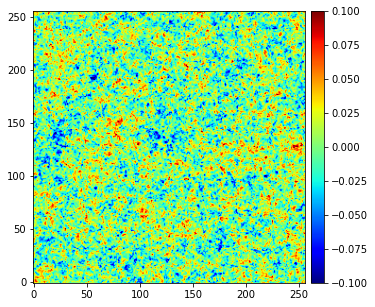

In [363]:
plot_slice(delta_lin,int(nc/2))

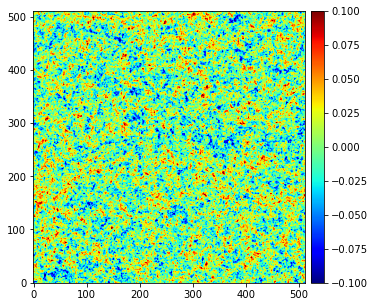

In [364]:
plot_slice(a2.real,int(nc2/2))

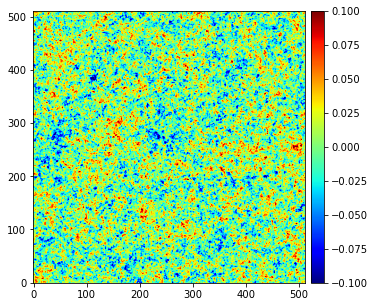

In [381]:
plot_slice(cgrf.real,int(nc2/2))

In [379]:
pk_delta = measure_autopk(cgrf.real,L)
pk_deltain = measure_autopk(delta_lin,L)

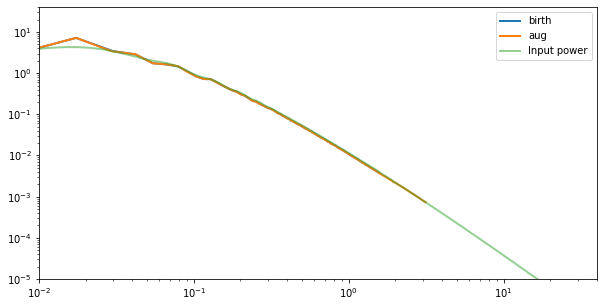

In [380]:
plt.figure(figsize=(10,5))
plt.plot(pk_deltain['k'].real,pk_deltain['power'].real,lw=2,label="birth")
plt.plot(pk_delta['k'].real,pk_delta['power'].real,lw=2,label="aug")
plt.plot(k,p,alpha=0.5,lw=2,label="Input power")
plt.loglog()
plt.xlim(0.01,40)
plt.ylim(1E-5,4E1)
plt.legend()